In [1]:
#!/usr/bin/env python`
# -*- coding: utf-8 -*-

In [42]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import sys

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
print(fn_plot_tf_hist.__doc__)


    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    


In [4]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = './models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 101  # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001  # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

In [7]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [8]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
#data_df.head()

In [9]:
for col in data_df.columns :
    print(f'{col} : {data_df[col].unique()}')

Unnamed: 0 : [    0     1     2 ... 18204 18205 18206]
ID : [158023  20801 190871 ... 241638 246268 246269]
Name : ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age : [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo : ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality : ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Sweden' 'Korea Republic' 'Finland' 'Guinea'
 'Montenegro' 'Armenia' '

In [10]:
data_df['Position'].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
18202    False
18203    False
18204    False
18205    False
18206    False
Name: Position, Length: 18147, dtype: bool

In [11]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [12]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [13]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [14]:
data_df = data_df[rel_cols]
#data_df.head()

In [65]:
labels101 = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [16]:
features_df = data_df.drop('Position', axis = 1)
labels = data_df['Position']

In [17]:
data_df['Position'].isnull().sum()

0

In [18]:
# splitting in train ans test datasets
X_train, X_test, y_train, y_test = train_test_split(features_df, labels,
                                     stratify=labels,
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

In [19]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [1]:
# important to reset the indies as we will be fetching by index

#X_train = X_train.reset_index(drop=True)
#display (X_train.head())

#X_test = X_test.reset_index(drop=True)
#display(X_test.head())

In [27]:
list(labels.keys())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
'''fig, axes = plt.subplots(1,2)
ax = axes[0]
train_df['Position'].value_counts().plot(kind = "bar", ax = ax);

ax = axes[1]
test_df['Position'].value_counts().plot(kind = "bar", ax = ax);'''

In [29]:
#1st model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(18, activation=tf.nn.silu), #alternatively activation
    tf.keras.layers.Dense(4) #notice absense of softmax function
])
#silu activation function is used here
#instead of silu we can also use relu and sigmoid etc

In [31]:
#functional api   #2nd model 
inputs = tf.keras.Input(shape=(33,))

x = tf.keras.layers.Dense(18, activation = tf.nn.relu)(inputs)  #33+4=37/2=18 , here 4 = layers, 33 = features

outputs = tf.keras.layers.Dense(4)(x)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [32]:
X_train[:1].shape  #column 1

(1, 33)

In [33]:
X_train[:1]

array([[ 0.84396466,  0.27358763, -0.52239617,  0.23109725,  0.29705091,
        -0.28022877, -0.90549975, -0.76923736,  0.03641655,  0.69690341,
         0.56150403,  0.64223997, -0.31191556,  0.42687437,  0.09102389,
        -0.00583853, -0.0156703 , -0.26906524,  0.14948988, -0.39569289,
        -1.58556533,  0.56596068, -0.45127189,  0.92378593, -0.5824395 ,
        -1.31972485, -1.46321229, -1.58353669, -0.31775841, -0.55501322,
        -0.37748688, -0.25744747, -0.31840455]])

In [34]:
predictions = model(X_train[:1]).numpy()
predictions

array([[-0.15677619, -0.7253082 , -0.960656  , -0.25390872]],
      dtype=float32)

In [35]:
predictions.sum()

-2.096649

In [36]:
tf.nn.softmax(predictions).numpy()

array([[0.34230387, 0.19386591, 0.15321144, 0.31061876]], dtype=float32)

In [37]:
tf.nn.softmax(predictions).numpy().sum()

1.0

In [ ]:
'''
 no. of parameters:
 layer 1 : 33*18 + 18 = 612
 layer 2 : 18*4 + 4 = 76
'''

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (1, 18)                   612       
                                                                 
 dense_5 (Dense)             (1, 4)                    76        
                                                                 
Total params: 688 (2.69 KB)
Trainable params: 688 (2.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
pred1 = model1(X_train[:1]).numpy()

In [40]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_7 (Dense)             (None, 18)                612       
                                                                 
 dense_8 (Dense)             (None, 4)                 76        
                                                                 
Total params: 688 (2.69 KB)
Trainable params: 688 (2.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#we dont specify softmax and sigmoid in last layer, it gets by its own

In [ ]:
#categorical cross entropy loss 

In [43]:
sys.float_info.max

1.7976931348623157e+308

In [44]:
sys.float_info.min

2.2250738585072014e-308

In [45]:
np.log(sys.float_info.max)

709.782712893384

In [46]:
np.exp(710)

C:\Users\Administrator.DAI-PC2\AppData\Local\Temp\ipykernel_18304\574927170.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(710)


inf

In [47]:
#here we tell our model that we have not coded for loss function, you take care of it
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy ( from_logits = True)

In [48]:
y_train[:1]

14537    3
Name: Position, dtype: int8

In [49]:
loss_fn(y_train[:1], predictions).numpy()

1.169189

In [50]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [51]:
history = model.fit(X_train, y_train, 
                    validation_data=[X_test, y_test],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/101


454/454 [==============================] - 3s 4ms/step - loss: 0.5308 - accuracy: 0.7931 - val_loss: 0.3756 - val_accuracy: 0.8402
Epoch 2/101
454/454 [==============================] - 1s 3ms/step - loss: 0.3403 - accuracy: 0.8611 - val_loss: 0.3307 - val_accuracy: 0.8567
Epoch 3/101
454/454 [==============================] - 1s 3ms/step - loss: 0.3150 - accuracy: 0.8697 - val_loss: 0.3168 - val_accuracy: 0.8634
Epoch 4/101
454/454 [==============================] - 1s 3ms/step - loss: 0.3038 - accuracy: 0.8743 - val_loss: 0.3124 - val_accuracy: 0.8634
Epoch 5/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2990 - accuracy: 0.8752 - val_loss: 0.3056 - val_accuracy: 0.8697
Epoch 6/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2949 - accuracy: 0.8799 - val_loss: 0.3026 - val_accuracy: 0.8675
Epoch 7/101
454/454 [==============================] - 1s 3ms/step - loss: 0.2924 - accuracy: 0.8779 - val_loss: 0.3003 - val_accuracy: 0.87

In [52]:
model.evaluate ( X_test,  y_test, verbose=2)

114/114 - 0s - loss: 0.3022 - accuracy: 0.8769 - 296ms/epoch - 3ms/step


[0.3022476136684418, 0.8768594861030579]

In [53]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.530779,0.793139,0.375551,0.840220
1,0.340307,0.861059,0.330658,0.856749
2,0.314974,0.869670,0.316836,0.863361
3,0.303849,0.874285,0.312369,0.863361
4,0.299035,0.875250,0.305604,0.869697


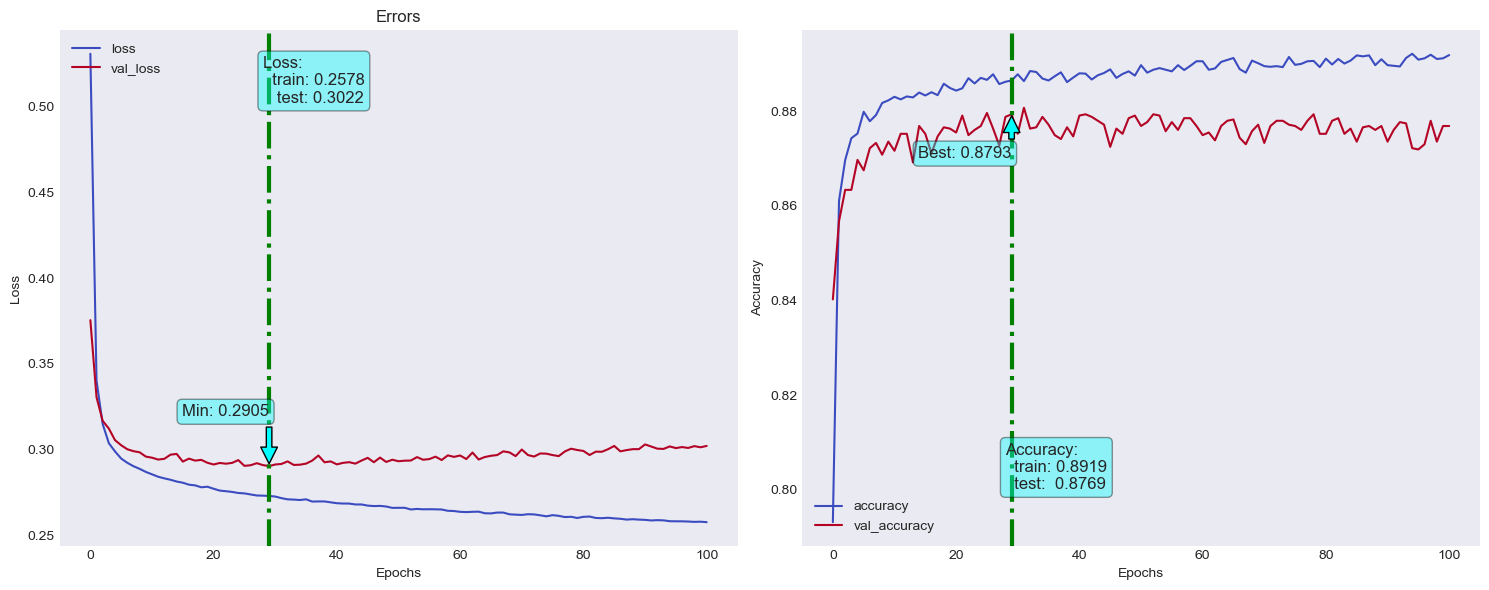

In [54]:
fn_plot_tf_hist(loss_df)

# predictions

In [55]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
29,0.27309,0.886478,0.290483,0.879339


In [56]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [57]:
y_pred = probability_model(X_train).numpy()
y_pred

array([[5.7193822e-10, 2.8920224e-08, 2.2296498e-02, 9.7770351e-01],
       [2.1248137e-10, 1.7911043e-08, 6.2401181e-01, 3.7598816e-01],
       [1.4680128e-10, 4.7503011e-08, 7.6443827e-01, 2.3556170e-01],
       ...,
       [1.0000000e+00, 4.3794253e-11, 1.7147122e-12, 8.2952390e-13],
       [1.0000000e+00, 8.4965238e-13, 4.0785509e-13, 5.5711395e-12],
       [1.0000000e+00, 2.2220339e-13, 1.9714508e-12, 5.0853061e-13]],
      dtype=float32)

In [58]:
print(classification_report( y_train, y_pred.argmax( axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.92      0.94      0.93      4693
           2       0.85      0.87      0.86      5470
           3       0.87      0.78      0.82      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.90     14517
weighted avg       0.89      0.89      0.89     14517



In [59]:
y_pred = probability_model(X_test).numpy()

print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(y_test, 
                                                                  np.argmax(y_pred, axis = 1))))

Accuracy score on Test Data :0.87686


In [60]:
print(classification_report(y_test, 
                            np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.91      0.94      0.92      1173
           2       0.83      0.86      0.84      1368
           3       0.84      0.74      0.79       684

    accuracy                           0.88      3630
   macro avg       0.90      0.88      0.89      3630
weighted avg       0.88      0.88      0.88      3630



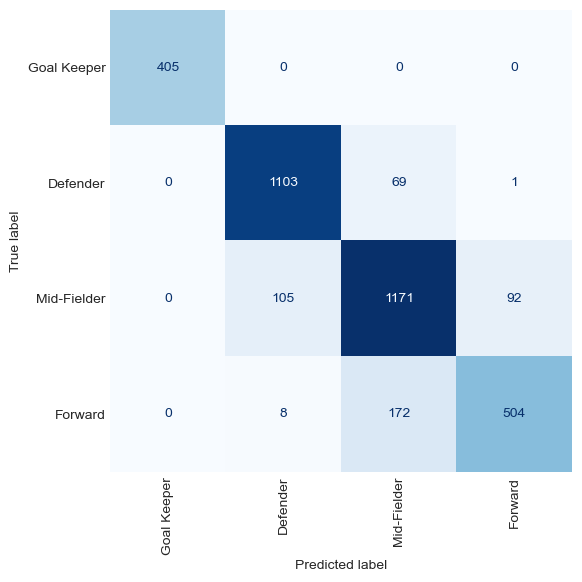

In [66]:
fn_plot_confusion_matrix( y_test, y_pred.argmax( axis = 1), labels=labels101)